In [96]:
# The code was removed by Watson Studio for sharing.

In [197]:
# !conda install -c conda-forge pydotplus -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

### Import the required libraries

In [252]:
import pandas as pd
import numpy as np


from sklearn.utils import resample                                 # For downscaling


 
from sklearn.preprocessing import LabelEncoder                     # For encoding the categorical variable in the dataset


import seaborn as sns                                              # for analyzing our dataset
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler as SS             # for Normalization of data

from sklearn.model_selection import train_test_split as tts        # for splitting our dataset

from sklearn.neighbors import KNeighborsClassifier as KNN          # for K Nearest Neighbor 

from sklearn.tree import DecisionTreeClassifier as DTC             # for Decision Tree and also plotting the tree
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree 


from sklearn.linear_model import LogisticRegression as LR          # for Logistic Regression


from sklearn.metrics import jaccard_similarity_score               # for Evaluation of our models
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

#### Downloading the .csv file

In [220]:
!wget -O  "Data-Collisions.csv" https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

--2020-08-29 22:14:44--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘Data-Collisions.csv’

100%[======================================>] 73,917,638  2.88MB/s   in 19s    

2020-08-29 22:15:04 (3.63 MB/s) - ‘Data-Collisions.csv’ saved [73917638/73917638]



<br>

**Now that we have downloaded the csv file, let us create our dataframe using pandas read_csv() function.**

In [234]:
df = pd.read_csv('Data-Collisions.csv')

In [222]:
# The code was removed by Watson Studio for sharing.

In [236]:
# We shall check the summary of our dataset, so that we can get an idea as to what we are dealing with.

# df.describe(include='all')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

**As we can see, there are a number of columns that we are not interested in right now. So, let us select the ones that seems suitable for our use case.**

In [237]:
df=df[['SEVERITYCODE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 4 columns):
SEVERITYCODE    194673 non-null int64
WEATHER         189592 non-null object
ROADCOND        189661 non-null object
LIGHTCOND       189503 non-null object
dtypes: int64(1), object(3)
memory usage: 5.9+ MB
None


**There are a number of null values (or blanks) in our dataset. We shall use the dropna function to search the required subset for null values are remove the entire rows.**

In [238]:
df.dropna(subset=['WEATHER','ROADCOND','LIGHTCOND'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189337 entries, 0 to 194672
Data columns (total 4 columns):
SEVERITYCODE    189337 non-null int64
WEATHER         189337 non-null object
ROADCOND        189337 non-null object
LIGHTCOND       189337 non-null object
dtypes: int64(1), object(3)
memory usage: 7.2+ MB


**Perfect!!!** <br>**But we are not done yet. Now we'll have to check the balance of the 'SEVERITYCODE', which is the dependent feature in our dataset. A perfectly balanced dataset with result in better performance while modeling. Otherwise, our model would be biased.**

In [239]:
df['SEVERITYCODE'].value_counts()

1    132285
2     57052
Name: SEVERITYCODE, dtype: int64

**We can see that there are only two types of severity codes in our dataframe, 1 and 2, being property damage and mild injury respectively. However, the class 1 is more than twice of class 2. We can downsample class 1 to fix this issue.**

In [240]:
# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]

n=len(df_minority)

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=n,      # to match minority class
                                 random_state=50)  # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.SEVERITYCODE.value_counts()

2    57052
1    57052
Name: SEVERITYCODE, dtype: int64

**We need to convert the categorical values in our dataset to numerical values for that they can be fed to our models later. For this we are using Label Encoder from sklearn.**

In [241]:
df_downsampled.WEATHER.value_counts()

Clear                       68159
Raining                     20643
Overcast                    16877
Unknown                      7066
Snowing                       475
Other                         420
Fog/Smog/Smoke                351
Sleet/Hail/Freezing Rain       64
Blowing Sand/Dirt              33
Severe Crosswind               13
Partly Cloudy                   3
Name: WEATHER, dtype: int64

In [242]:
lb = LabelEncoder()

df_downsampled['WEATHER_CAT'] = lb.fit_transform(df_downsampled['WEATHER'])
df_downsampled['ROAD_CAT'] = lb.fit_transform(df_downsampled['ROADCOND'])
df_downsampled['LIGHT_CAT'] = lb.fit_transform(df_downsampled['LIGHTCOND'])

df_downsampled.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEATHER_CAT,ROAD_CAT,LIGHT_CAT
71757,1,Overcast,Dry,Daylight,4,0,5
102817,1,Clear,Wet,Daylight,1,8,5
112456,1,Raining,Dry,Dark - Street Lights On,6,0,2
21794,1,Overcast,Dry,Dark - Street Lights On,4,0,2
189098,1,Overcast,Dry,Daylight,4,0,5


In [243]:
df_new = df_downsampled[['SEVERITYCODE', 'WEATHER_CAT', 'ROAD_CAT', 'LIGHT_CAT']]

### Explporatory Data Analysis

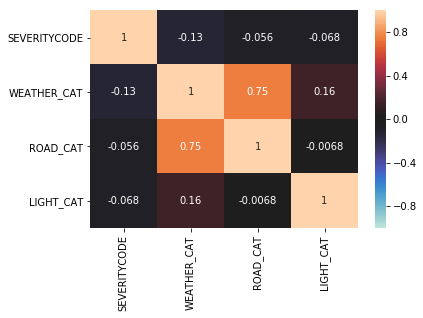

In [256]:
sns.heatmap(df_new.corr(), annot = True, vmin=-1, vmax=1, center= 0)

In [257]:
# The code was removed by Watson Studio for sharing.

In [253]:
pearson_coeff, p_value = pearsonr(df_new['WEATHER_CAT'],df_new['SEVERITYCODE'])
print(pearson_coeff, p_value)

-0.1297625454272009 0.0


In [254]:
pearson_coeff, p_value = pearsonr(df_new['ROAD_CAT'],df_new['SEVERITYCODE'])
print(pearson_coeff, p_value)

-0.05600249799190999 6.228356863762197e-80


In [255]:
pearson_coeff, p_value = pearsonr(df_new['LIGHT_CAT'],df_new['SEVERITYCODE'])
print(pearson_coeff, p_value)

-0.0683583167728117 3.070475783449797e-118



### Feature Selection

Now we shall feed our dataset to the Machine Learning Algorithms. We will be using 3 of them here, namely, KNN, Decision Tree and Logistic Regression.

In [245]:
# Initialization
X = np.asarray(df_new[['WEATHER_CAT', 'ROAD_CAT', 'LIGHT_CAT']]).astype(float)
y = np.asarray(df_new['SEVERITYCODE']).astype(float)
y[0:5]

array([1., 1., 1., 1., 1.])

### Normalize the dataset

In [246]:
X = SS().fit_transform(X)
X[0:5]

array([[ 0.38539418, -0.69458687,  0.39185293],
       [-0.71972789,  1.50151555,  0.39185293],
       [ 1.12214222, -0.69458687, -1.42886541],
       [ 0.38539418, -0.69458687, -1.42886541],
       [ 0.38539418, -0.69458687,  0.39185293]])

### Splitting  the dataset

In [247]:
# Splitting the dataset into train and test set
X_train,X_test,y_train,y_test = tts(X, y, test_size=0.3, random_state=45)
print("Train Set:",X_train.shape,y_train.shape)
print("Test Set:",X_test.shape,y_test.shape)

Train Set: (79872, 3) (79872,)
Test Set: (34232, 3) (34232,)


### K Nearest Neighbor (KNN)

In [248]:
# First, we are going to use the K Nearest Neighbor (KNN) Algorithm.

#Train Model and Predict
k=3
kNN_model = KNN(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [249]:
# just for sanity chaeck
yhat = kNN_model.predict(X_test)
yhat[0:5]

array([2., 2., 2., 2., 2.])

In [250]:
# Best k
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNN(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.55307899, 0.54262094, 0.55363403, 0.55302057, 0.5545104 ,
       0.51589156, 0.55442276, 0.5474702 , 0.55564968, 0.55538677,
       0.55430591, 0.55483174, 0.5545104 , 0.55494859])

In [204]:
# Building the model again, using k=5
k = 5
#Train Model and Predict  
kNN_model = KNN(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

**KNN Model Evaluation**

In [205]:
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, yhat, average='weighted') )

KNN Jaccard index: 0.55
KNN F1-score: 0.52


### Decision Tree

In [206]:
DT_model = DTC(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [207]:
yhat1 = DT_model.predict(X_test)
yhat1

array([2., 2., 1., ..., 1., 1., 2.])

**Decision Tree Model Evaluation**

In [208]:
print("DT Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat1))
print("DT F1-score: %.2f" % f1_score(y_test, yhat1, average='weighted') )

DT Jaccard index: 0.56
DT F1-score: 0.53


### Logistic Regression

In [192]:
LR_model = LR(C=0.01,solver='liblinear').fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [193]:
yhat2 = LR_model.predict(X_test)
yhat2

array([2, 2, 2, ..., 2, 2, 2])

**Logistic Regression Model Evaluation**

In [194]:
yhat_prob = LR_model.predict_proba(X_test)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(y_test, yhat2))
print("LR F1-score: %.2f" % f1_score(y_test, yhat2, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(y_test, yhat_prob))

LR Jaccard index: 0.54
LR F1-score: 0.53
LR LogLoss: 0.68


# Report

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.55    | 0.52     | NA      |
| Decision Tree      | 0.56    | 0.53     | NA      |
| LogisticRegression | 0.54    | 0.53     | 0.68    |
<br>

Even though the first two algorithms look promising, it is Logistic Regression that makes sense because of its binary nature. So we will proceed with Logistic Regression algorithm as our model.